# <u>**Tackling a Realistic Physics Problem : How to approach it? What needs to be considered?**</u>
<h4>
<u>Content</u>: <br> 
0. Introducing our physics Example : Lagrangian Generation <br>
1. Datasets : Distributions and Tokenization <br>
2. Training : Where to find resources!<br>
3. Evaluations : Metric vs Score, Embedding Analysis, Out-Of-Domain Generalization<br>
</h4>

---
---


# 0. **Physics Example : Lagrangian Generation!**

### **<u>Model Task</u>**
<img src="https://i.imgur.com/dGfUOPB.png" alt="Distribtuion" width="900">

Reference: https://arxiv.org/abs/2501.09729


### **<u>Inference</u>**

Before anything else, load some basic libraries :)


In [1]:
# Uncomment and run this if youre doing via google collab
#!git clone https://github.com/kys-sheng/AI4Physics-learning-workshop

In [2]:
# Uncomment and run this if youre doing via google collab
# import sys
# sys.path.append('/content/AI4Physics-learning-workshop')  # Adjust path as needed# Uncomment and run this if youre doing via google collab
# import os 
# os.chdir('/content/AI4Physics-learning-workshop')

In [3]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import random 
%matplotlib inline

import torch
import lag_eval as le
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Checking Tokens Format
particle_id_token          :  ['ID1']
derivative_id_token        :  ['ID1']
gamma_id_token             :  ['ID1']
sigma_id_token(1)          :  ['ID1']
spin_token(0)              :  ['SPIN', '0']
spin_token(1)              :  ['SPIN', '1']
spin_token(Fraction(1,2))  :  ['SPIN', '1/2']
helicity_token(1)          :  ['HEL', '1/2']
helicity_token(-1)         :  ['HEL', '-1/2']
group_tokens(1)            :  ['U1']
group_tokens(1,test)            :  ['U1', '_{test}']
group_tokens(2)            :  ['SU2']
group_tokens(2,test)            :  ['SU2', '_{test}']
group_tokens(3)            :  ['SU3']
group_tokens(3,test)            :  ['SU3', '_{test}']
Tokens Format OK


In [4]:
print("Youre using: ",device)

Youre using:  cuda


#### Load our model and tokenizer

In [5]:
# Load our BART-L model and tokenizer if not yet loaded
model_name   = "JoseEliel/BART-Lagrangian"
model        = BartForConditionalGeneration.from_pretrained(model_name).to(device)
hf_tokenizer = PreTrainedTokenizerFast.from_pretrained(model_name)

/cephyr/users/koay/Alvis/venv/jammymod/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/apps/Arch/software/PyTorch/2.1.2-foss-2023a-CUDA-12.1.1/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


#### Lets write a Higgs-only Lagrangian with BART-L

In [6]:
higgs           = "FIELD SPIN 0 SU2 2 U1 1"
    
example_input   = "[SOS] "+higgs+" [EOS]"
print("Input    = ",example_input)

encoded_input   = hf_tokenizer.encode(example_input)
print("token_id = ", encoded_input)

Input    =  [SOS] FIELD SPIN 0 SU2 2 U1 1 [EOS]
token_id =  [0, 22, 36, 9, 37, 6, 39, 5, 1]


#### Generate the Lagrangian!

In [7]:
model.eval()
with torch.no_grad():
    # Generate the ids for the Lagrangians
    generated_id     = model.generate(input_ids=torch.tensor(encoded_input).unsqueeze(0).to(device), max_length=1024)
    # Decode it!
    predicted_string = hf_tokenizer.decode(generated_id[0].to(device), skip_special_tokens=True)

print("Predicted : ", )
for i in le.sep_terms(predicted_string):
    print(" ".join(i))    

Predicted : 
+ FIELD SPIN 0 SU2 2 U1 1 ID4 FIELD SPIN 0 SU2 2 U1 1 ID7 FIELD SPIN 0 SU2 2 U1 - 1 DAGGER ID0 FIELD SPIN 0 SU2 2 U1 - 1 DAGGER ID9 CONTRACTIONS SU2 ID4 ID0 SU2 ID7 ID9
+ FIELD SPIN 0 SU2 2 U1 1 ID6 FIELD SPIN 0 SU2 2 U1 1 ID4 FIELD SPIN 0 SU2 2 U1 - 1 DAGGER ID2 FIELD SPIN 0 SU2 2 U1 - 1 DAGGER ID0 CONTRACTIONS SU2 ID6 ID4 SU2 ID2 ID0
+ DERIVATIVE SU2 U1 ID6 FIELD SPIN 0 SU2 2 U1 - 1 DAGGER ID7 DERIVATIVE SU2 U1 ID0 FIELD SPIN 0 SU2 2 U1 1 ID4 CONTRACTIONS LORENTZ ID6 ID0 SU2 ID7 ID4
- COMMUTATOR_A DERIVATIVE SU2 ID6 COMMUTATOR_B DERIVATIVE SU2 ID0 COMMUTATOR_A DERIVATIVE SU2 ID4 COMMUTATOR_B DERIVATIVE SU2 ID1 CONTRACTIONS LORENTZ ID6 ID4 LORENTZ ID0 ID1
- COMMUTATOR_A DERIVATIVE U1 ID6 COMMUTATOR_B DERIVATIVE U1 ID0 COMMUTATOR_A DERIVATIVE U1 ID4 COMMUTATOR_B DERIVATIVE U1 ID1 CONTRACTIONS LORENTZ ID6 ID4 LORENTZ ID0 ID1
+ FIELD SPIN 0 SU2 2 U1 - 1 DAGGER ID6 FIELD SPIN 0 SU2 2 U1 1 ID7 CONTRACTIONS SU2 ID6 ID7


An example of a translation table:

<img src="https://i.imgur.com/qD94qCd.png" alt="Distribtuion" width="1000">


## For a more interactive latex version of our model, see : https://huggingface.co/spaces/JoseEliel/generate-lagrangians

---
---

<h1>
Now comes the important parts, if you wanna start your project :  <br>
<h2>
 - How to approach it?  <br>
 - What needs to be considered? <br>

---
---

# 1. **Preparing your Dataset**


<h2> Main point : NN are good interpolators, but not that good of an extrapolator. (Recall Niklas' talk) </h2> 
<h4>
- NN learns from data. <br>
- If the model is given something it has never seen, it figure outs based on existing experience  <br>
- Training Data Distribution matters! <br>

---

# **1a. Data Distribution**

<h4>
What do you need to think about? Where to start?    <br>

**Rule of Thumb** : Think of your use case, and go from there!  <br>

---

## Example in Math  : x + y => ? 


### Use case :
<div align="center">
     <h4> add any two numbers independent of the number's digits, <br> be it between 1-digit numbers (2+2) or 5-digit numbers (20000+16378) or something in between (42+2025)</h4>
</div>


### So, Lets have a look at the digits of our numbers in the datasets!

Let's generate numbers from 1-10000 and do addition as before

In [8]:
num_examples = 10000
min_num      = 1
max_num      = 10000

# Generate random examples
examples     = [(random.randint(min_num, max_num),random.randint(min_num, max_num)) for _ in range(num_examples)]
df           = pd.DataFrame(examples, columns=['x', 'y'])
df['sum']    = df['x'] + df['y']

print(f"Example: {df['x'].iloc[0]} + { df['y'].iloc[0]} = { df['sum'].iloc[0]}")
print(f"Example: {df['x'].iloc[1]} + { df['y'].iloc[1]} = { df['sum'].iloc[1]}")
print(f"Example: {df['x'].iloc[2]} + { df['y'].iloc[2]} = { df['sum'].iloc[2]}")


Example: 2111 + 2623 = 4734
Example: 6683 + 2358 = 9041
Example: 9477 + 8605 = 18082


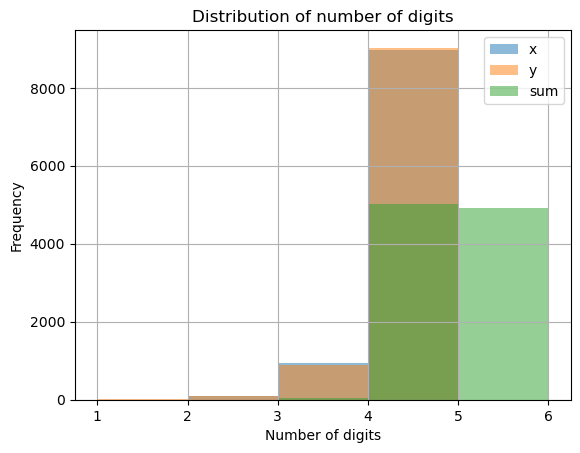

In [9]:
# Lets compute the number of digits in each number
df['x_digit']   = df['x'].apply(lambda x: len(str(x)))    
df['y_digit']   = df['y'].apply(lambda x: len(str(x)))    
df['sum_digit'] = df['sum'].apply(lambda x: len(str(x)))

# Plot the distribution of number of digits
df['x_digit'].hist(label="x",range=(1,6),bins=5,alpha=0.5)
df['y_digit'].hist(label="y",range=(1,6),bins=5,alpha=0.5)
df['sum_digit'].hist(label="sum",range=(1,6),bins=5,alpha=0.5)
plt.legend()
plt.title("Distribution of number of digits")
plt.xlabel("Number of digits")  
plt.ylabel("Frequency")
plt.show()


### Probability of the model learning addition with **both numbers** having 1 digit, 2 digits, 3 digits, 4 digits, ...


In [10]:
print("P(both_digit=1) = ", len(df[(df["x_digit"] == 1) & (df["y_digit"] == 1)]) / num_examples)
print("P(both_digit=2) = ", len(df[(df["x_digit"] == 2) & (df["y_digit"] == 2)]) / num_examples)
print("P(both_digit=3) = ", len(df[(df["x_digit"] == 3) & (df["y_digit"] == 3)]) / num_examples)
print("P(both_digit=4) = ", len(df[(df["x_digit"] == 4) & (df["y_digit"] == 4)]) / num_examples)
print("P(both_digit=5) = ", len(df[(df["x_digit"] == 5) & (df["y_digit"] == 5)]) / num_examples)


P(both_digit=1) =  0.0
P(both_digit=2) =  0.0001
P(both_digit=3) =  0.0073
P(both_digit=4) =  0.8094
P(both_digit=5) =  0.0


### Probability of the model learning addition that gives a sum with 1 digit, 2 digits, 3 digits, 4 digits, ...

In [11]:
print("P(sum_digit=1) = ", len(df[df["sum_digit"] == 1]) / num_examples)
print("P(sum_digit=2) = ", len(df[df["sum_digit"] == 2]) / num_examples)
print("P(sum_digit=3) = ", len(df[df["sum_digit"] == 3]) / num_examples)
print("P(sum_digit=4) = ", len(df[df["sum_digit"] == 4]) / num_examples)
print("P(sum_digit=5) = ", len(df[df["sum_digit"] == 5]) / num_examples)


P(sum_digit=1) =  0.0
P(sum_digit=2) =  0.0001
P(sum_digit=3) =  0.0046
P(sum_digit=4) =  0.503
P(sum_digit=5) =  0.4923


### What you should do then in this case? 
- Oversample the low-digit cases! : 
    - They showed how Data Distribution affects GCD use-case
    - https://arxiv.org/pdf/2308.15594 
- Architectural choices          : 
    - introduce Continuous Numerical Tokenization [Treat numbers as numbers instead of alphabet like]
    - https://arxiv.org/abs/2310.02989 

---

## Example in Lagrangian Generation
<div align="center">
     <h2> A , B, C -> L(A,B,C) </h2>
</div>

### Use Case : 
A. Want to work with different number of fields : A,B,C,D,E,F <br>
B. Want work with varying interactions : Quartic, Yukawa, Trilinears<br>

### We generated two datasets to look into this: 
- Uniform Distribution : Randomly Generated <br>
<img src="https://i.imgur.com/s4MJA9v.png" alt="Distribtuion" width="500"><br>

- Sampled Distribution : More trilinears (harder to get if randomly sample) but less large number of fields (Train Set Priming) <br>    
<img src="https://i.imgur.com/K7p8fLR.png" alt="Distribtuion" width="500"><br>



Reference : Train set priming https://arxiv.org/abs/2306.15400

# Takeaway: Build your data around your use case!
---

# **1b. Tokenization choices** : How detail should your tokenization be?

In Language:
Example Phrase : AI For Physics
- Word-Level : AI, For, Physics
- Character-Level : A, I,  , F, o, r,  , P, h, y, s, i, c, s

In Math:
Example Expression : 100 + 420 = 520
- "Term"-level : 100, +, 420, =, 520
- "Digit"-Level : 1, 0, 0,  +,  4, 2, 0, =,  5, 2, 0

In Lagrangians:
Example Field : Higgs Particle
- Symbol Level : H
- Quantum-Numbers-Level: FIELD, SPIN, 0, SU2, 2, U1, 1



You can already see from these examples that the number of tokens changes! Any consequences?

---

## Vocab Size vs Number of Tokens 

### Math Example : Tokenizing Numbers 

In [12]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

# Character-level 
# 1. Generate arithmetic corpus as before
num_examples = 10000
min_num      = 0
max_num      = 100000
examples     = [(random.randint(min_num, max_num),random.randint(min_num, max_num)) for _ in range(num_examples)]
digit_level_corpus = [" ".join(list(f"{a}+{b}={str(a + b)}")) for a , b in examples]
vocab = {"1" : 1, "2" : 2, "3" : 3, "4" : 4, "5" : 5, "6" : 6, "7" : 7, "8" : 8, "9" : 9,
         "0" : 0, "+" : 10, "=" : 11,"[UNK]" : 12, "[PAD]" : 13, "[BOS]" : 14, "[EOS]" : 15}
         
# 2. Initialize tokenizer components
digit_level_tokenizer = Tokenizer(WordLevel(vocab=vocab, unk_token="[UNK]"))
digit_level_tokenizer.pre_tokenizer = Whitespace()

# Word-level 
term_level_corpus = [f"{a} + {b} = {str(a + b)}" for a , b in examples]
term_level_corpus.append("1 + 0 = 1")
term_level_tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
term_level_tokenizer.pre_tokenizer = Whitespace()
special_tokens = ["[PAD]", "[UNK]", "[BOS]", "[EOS]"]
trainer = WordLevelTrainer(special_tokens=special_tokens)
term_level_tokenizer.train_from_iterator(term_level_corpus, trainer)

for i in range(3):
    digit_level_example = random.choice(digit_level_corpus)
    print("digit_level_example     : ",digit_level_example)

print()
for i in range(3):
    term_level_example = random.choice(term_level_corpus)
    print("term_level_example     : ",term_level_example)

digit_level_example     :  8 2 1 0 1 + 7 6 1 9 = 8 9 7 2 0
digit_level_example     :  1 8 0 6 6 + 6 7 8 6 3 = 8 5 9 2 9
digit_level_example     :  1 6 2 9 8 + 4 9 4 8 8 = 6 5 7 8 6

term_level_example     :  67338 + 26523 = 93861
term_level_example     :  22880 + 27314 = 50194
term_level_example     :  97252 + 40980 = 138232


In [13]:
digit_level_example = random.choice(digit_level_corpus)
print("digit_level_tokens      : ",digit_level_tokenizer.encode(digit_level_example).tokens)
print("digit_level_Ntokens     : ",len(digit_level_tokenizer.encode(digit_level_example).tokens))
print("digit_level_vocab_size  : ",digit_level_tokenizer.get_vocab_size(),end="\n\n")

term_level_example = random.choice(term_level_corpus)
print("term_level_tokens      : ",term_level_tokenizer.encode(term_level_example).tokens)
print("term_level_Ntokens     : ",len(term_level_tokenizer.encode(term_level_example).tokens))
print("term_level_vocab_size  : ",term_level_tokenizer.get_vocab_size())

digit_level_tokens      :  ['2', '0', '8', '2', '8', '+', '3', '9', '4', '6', '=', '2', '4', '7', '7', '4']
digit_level_Ntokens     :  16
digit_level_vocab_size  :  16

term_level_tokens      :  ['92648', '+', '57428', '=', '150076']
term_level_Ntokens     :  5
term_level_vocab_size  :  26863


char_level/digit_level : less vocabulary <br>
word_level/term_level  : less tokens <br>

### Lagrangian Example : Higgs-Only Lagrangian

In [14]:
example_fields  = "FIELD SPIN 0 SU3 3 SU2 3 U1 6 FIELD SPIN 0 SU3 - 3 U1 - 7 / 2 "
example_input   = "[SOS] "+example_fields+" [EOS]"
encoded_input   = hf_tokenizer.encode(example_input)
model.eval()
with torch.no_grad():
    # Generate the ids for the Lagrangians
    generated_id     = model.generate(input_ids=torch.tensor(encoded_input).unsqueeze(0).to(device), max_length=1024)
    # Decode it!
    predicted_string = hf_tokenizer.decode(generated_id[0].to(device), skip_special_tokens=True)

print("Lagrangian_tokens                       : ",predicted_string.split())
print("Ntokens                                 : ",len(predicted_string.split()))
print("Vocabulary size                         : ", hf_tokenizer.vocab_size)

Lagrangian_tokens                       :  ['+', 'FIELD', 'SPIN', '0', 'SU3', '3', 'SU2', '3', 'U1', '6', 'ID7', 'FIELD', 'SPIN', '0', 'SU3', '-', '3', 'SU2', '3', 'U1', '-', '6', 'DAGGER', 'ID6', 'FIELD', 'SPIN', '0', 'SU3', '-', '3', 'U1', '-', '7', '/', '2', 'ID0', 'FIELD', 'SPIN', '0', 'SU3', '3', 'U1', '7', '/', '2', 'DAGGER', 'ID8', 'CONTRACTIONS', 'SU3', 'ID7', 'ID6', 'ID0', 'SU3', 'ID6', 'ID0', 'ID8', 'SU2', 'ID7', 'ID6', 'SU2', 'ID7', 'ID6', '+', 'FIELD', 'SPIN', '0', 'SU3', '3', 'SU2', '3', 'U1', '6', 'ID7', 'FIELD', 'SPIN', '0', 'SU3', '-', '3', 'SU2', '3', 'U1', '-', '6', 'DAGGER', 'ID6', 'FIELD', 'SPIN', '0', 'SU3', '-', '3', 'U1', '-', '7', '/', '2', 'ID0', 'FIELD', 'SPIN', '0', 'SU3', '3', 'U1', '7', '/', '2', 'DAGGER', 'ID4', 'CONTRACTIONS', 'SU3', 'ID7', 'ID6', 'ID6', 'SU3', 'ID0', 'ID0', 'ID4', 'SU2', 'ID7', 'ID6', 'SU2', 'ID7', 'ID6', '+', 'FIELD', 'SPIN', '0', 'SU3', '3', 'SU2', '3', 'U1', '6', 'ID7', 'FIELD', 'SPIN', '0', 'SU3', '3', 'SU2', '3', 'U1', '6', 'ID6', '

<img src="https://i.imgur.com/qD94qCd.png" alt="Distribtuion" width="1000">


## Is your tokenization method expressive enough to go beyond training data? (OOD Considerations)
### Math Example : Encoding 1000000000 [Your dataset were from 0 to 100000]

In [15]:
OOD_digit_level_example =   "1 0 0 0 0 0 0 0 0 0"
print("digit_level_tokens                : ",digit_level_tokenizer.encode(OOD_digit_level_example).tokens,end="\n\n")

OOD_term_level_example =   "1000000000"
print("term_level_tokens                : ",term_level_tokenizer.encode(OOD_term_level_example).tokens,end="\n\n")


digit_level_tokens                :  ['1', '0', '0', '0', '0', '0', '0', '0', '0', '0']

term_level_tokens                :  ['[UNK]']



since the word level tokenizer have never seen this number, it cant work with it.

In [16]:
# Something like this is possible but not intuitive (terms and number are slightly different)
print("term_level_tokens (work-around)  : ",term_level_tokenizer.encode(OOD_digit_level_example).tokens,end="\n\n")

term_level_tokens (work-around)  :  ['1', '0', '0', '0', '0', '0', '0', '0', '0', '0']



 There are work arounds, but then your model have never seen two numbers side by side, surely then it wont have a good idea of what it means. 

char_level/digit_level : more expressive and allows OOD generalization <br>
word_level/term_level  : less expressive and need to think of workarounds (less intuitive) <br>

# Takeaway :  Give and take between N_tokens and Vocabulary

### 1. Detailed tokenization : 
- less vocabulary -> - more expressive
- more token per sequence -> heavy on attention mechanism
### 2. Coarse tokenization : 
- more vocabulary -> less expressive
- less token per sequence -> easier on attention mechanism

## **Other Considerations:**
### A. What information is relevant/interesting for your model to learn?
#### Lagrangian Example: Covariant Derivatives 

In some case, we need to be creative : Covariant Derivatives are everywhere, Kinetic terms can be written with Derivatives, ... 

<img src="https://i.imgur.com/2yGqCVT.png" alt="Distribtuion" width="1000">


---
---
# 2. **Training** : Where to find resources?


### NAISS : https://www.naiss.se/
- Provider of compute and storage resources
- For any researchers based in Sweden



### SUPR : https://supr.naiss.se/
- Portal to apply for it. 
- There are varyind levels of applications [small, medium, large]
- PhD students and above can already apply for small compute (Alvis: 1000GPUhs/months and Dardel: 20000 CPU-h/month!)



### For GPU, we recommend:
#### Alvis : https://www.c3se.chalmers.se/about/Alvis/ <br> OnDemand Portal : https://alvis.c3se.chalmers.se/pun/sys/dashboard/


---
---

# 3. **Evaluation**

<h2>
To evaluate your model properly. <br>
Rule of Thumb : Again , think of your use case!
</h2>

------ 


<h2>
<u>A. Is Cross-Entropy Loss enough for your problem?</u>  (Think about permutation invariance, conservation laws, ...)
<h4>
  <ul>
    <li> Yes? -> Ignore. </li>
    <li> No? -> <b><u>Create your own metric</b></u> : See 3A</li>
  </ul>
</h4>

<h3>
For example, we define Lagrangian Score as:
<div align="center">
     <h4> S_Lagrangian = (N_correct - N_Extra) / N_true </h3>
</div>

where:
- N_correct = Number of correct terms
- N_Extra = Number of extra terms
- N_true = True Number of terms 

------ 

<h2>
B. Do you care whether the model internalizes the right concepts? (Relationship between symbols, or between inputs and outputs) 
<h4>
  <ul>
    <li> Yes? -> <b><u>Embedding Analysis</b></u> : See 3B</li> 
    <li> No? -> Continue </li>
  </ul>

<h3>
For example, did the model learned symmetry group and representations (Lorentz, SU3, SU2, U1)? Yes! <br>
<img src="https://i.imgur.com/ycNegGp.png" alt="Embeddings in LLM" width="500">

---

<h2>
C. Is your problem "infinite"(ie probability of getting an unseen data point is high)?  
<h4>
  <ul>
    <li>Yes? -> <b><u>OoD Generalization</b></u> : See 3C </li>
    <li>No? -> Continue </li>
  </ul>

<h3>
For example, can we go beyond 6 fields? <br>
<img src="https://i.imgur.com/yzdcPMB.png" alt="Embeddings in LLM" width="1000">

OOD Task can also lead to insights on the architectural constraints on task 

---

# 3A. Existing Metric  : Does it work? 

mainly to see if things work as expected
Loss : Deviation from actual term 
Accuracy : How much is perfect? 
New metric, Score : (Order does not always matter, XEN)

In [17]:
# Choose GPU if available
import torch
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import lag_eval as le
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast

# Load our BART-L model and tokenizer if not yet loaded
model_name   = "JoseEliel/BART-Lagrangian"
model        = BartForConditionalGeneration.from_pretrained(model_name).to(device)
hf_tokenizer = PreTrainedTokenizerFast.from_pretrained(model_name)

/cephyr/users/koay/Alvis/venv/jammymod/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [18]:
!tar -xzvf huggingface_dataset_sampled.tar.gz

huggingface_dataset_sampled.csv


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
# Load data if not already loaded, drop duplicates
sampled_df = pd.read_csv("huggingface_dataset_sampled.csv")
sampled_df.drop_duplicates(subset=["fields"], inplace=True)

In [20]:
sampled_df

,fields,Lagrangian,train/eval
0,FIELD SPIN 1/2 SU3 - 3 SU2 2 U1 - 4 HEL 1/2 FI...,+ FIELD SPIN 1 / 2 SU3 - 3 SU2 2 HEL - 1 / 2 D...,eval
1,FIELD SPIN 1/2 HEL 1/2 FIELD SPIN 1/2 SU3 - 3 ...,+ i FIELD SPIN 1 / 2 HEL 1 / 2 ID9 SIGMA_BAR I...,eval
2,FIELD SPIN 0 SU2 3 U1 - 4 / 9 FIELD SPIN 1/2 S...,+ FIELD SPIN 0 SU2 3 U1 - 4 / 9 ID1 FIELD SPIN...,eval
3,FIELD SPIN 1/2 SU3 - 3 U1 3 / 8 HEL -1/2 FIELD...,+ FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 8 / 9 ID3 FI...,eval
4,FIELD SPIN 0 SU3 3 SU2 3,+ FIELD SPIN 0 SU3 3 SU2 3 ID4 FIELD SPIN 0 SU...,eval
...,...,...,...
286076,FIELD SPIN 0 SU3 3 SU2 3 U1 9 / 2 FIELD SPIN 1...,+ FIELD SPIN 1 / 2 SU2 2 U1 1 / 5 HEL - 1 / 2 ...,train
286077,FIELD SPIN 0 FIELD SPIN 0 SU3 3 SU2 3 U1 7 / 6...,+ FIELD SPIN 0 ID1 FIELD SPIN 0 SU3 3 SU2 3 U1...,train
286078,FIELD SPIN 0 SU3 - 3 U1 3 FIELD SPIN 1/2 SU3 3...,+ FIELD SPIN 0 SU3 - 3 U1 3 ID4 FIELD SPIN 0 S...,train
286079,FIELD SPIN 1/2 U1 - 4 / 5 HEL -1/2 FIELD SPIN ...,+ FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 / 7 ID6 FI...,train


### Example : Lagrangian Score

Choose a random lagrangian to work with

In [21]:
example_scenario = sampled_df.sample(1)

Look at the input (field content) and the output (Lagrangian)

In [22]:
example = example_scenario["fields"].values[0]
example_input = "[SOS] " + example + " [EOS]"
print("Input    = ",example_input)
encoded_input = hf_tokenizer.encode(example_input)
print("token_id = ", encoded_input)
decoded_input = hf_tokenizer.decode(encoded_input)
print("decoded  = ", decoded_input)
print()
example = example_scenario["Lagrangian"].values[0]
example_output = "[SOS] " + example + " [EOS]"
print("Output   = ",example_output)
encoded_output = hf_tokenizer.encode(example_output)
print("token_id = ", encoded_output)
decoded_output = hf_tokenizer.decode(encoded_output)
print("decoded  = ", decoded_output)


Input    =  [SOS] FIELD SPIN 1/2 SU3 3 U1 - 5 / 2 HEL 1/2 FIELD SPIN 0 SU2 3 U1 - 1 FIELD SPIN 1/2 SU3 3 SU2 3 U1 7 / 4 HEL 1/2 FIELD SPIN 0 U1 - 2 FIELD SPIN 1/2 SU2 2 U1 - 7 / 3 HEL -1/2 FIELD SPIN 0 SU3 - 3 U1 9 [EOS]
token_id =  [0, 22, 36, 5, 4, 6, 38, 10, 39, 7, 12, 4, 6, 23, 5, 4, 6, 22, 36, 9, 37, 10, 39, 7, 5, 22, 36, 5, 4, 6, 38, 10, 37, 10, 39, 14, 4, 11, 23, 5, 4, 6, 22, 36, 9, 39, 7, 6, 22, 36, 5, 4, 6, 37, 6, 39, 7, 14, 4, 10, 23, 7, 5, 4, 6, 22, 36, 9, 38, 7, 10, 39, 16, 1]
decoded  =  [SOS] FIELD SPIN 1 / 2 SU3 3 U1 - 5 / 2 HEL 1 / 2 FIELD SPIN 0 SU2 3 U1 - 1 FIELD SPIN 1 / 2 SU3 3 SU2 3 U1 7 / 4 HEL 1 / 2 FIELD SPIN 0 U1 - 2 FIELD SPIN 1 / 2 SU2 2 U1 - 7 / 3 HEL - 1 / 2 FIELD SPIN 0 SU3 - 3 U1 9 [EOS]

Output   =  [SOS] + FIELD SPIN 0 SU2 3 U1 - 1 ID9 FIELD SPIN 0 SU2 3 U1 - 1 ID1 FIELD SPIN 0 U1 2 DAGGER ID0 CONTRACTIONS SU2 ID9 ID1 SU2 ID9 ID1 + FIELD SPIN 0 SU2 3 U1 1 DAGGER ID8 FIELD SPIN 0 SU2 3 U1 1 DAGGER ID1 FIELD SPIN 0 U1 - 2 ID4 CONTRACTIONS SU2 ID8 ID1 SU2 

Look at the output (Lagrangian)

In [23]:
# show the terms 
separated_terms = le.sep_terms(decoded_output)

print("First five terms: ")
for i in range(len(separated_terms)):
    if i>4: break
    print(f"term {i+1} : "," ".join(separated_terms[i]))
    
lag_truth_1 =  " ".join([" ".join(i) for i in separated_terms])

First five terms: 
term 1 :  + FIELD SPIN 0 SU2 3 U1 - 1 ID9 FIELD SPIN 0 SU2 3 U1 - 1 ID1 FIELD SPIN 0 U1 2 DAGGER ID0 CONTRACTIONS SU2 ID9 ID1 SU2 ID9 ID1
term 2 :  + FIELD SPIN 0 SU2 3 U1 1 DAGGER ID8 FIELD SPIN 0 SU2 3 U1 1 DAGGER ID1 FIELD SPIN 0 U1 - 2 ID4 CONTRACTIONS SU2 ID8 ID1 SU2 ID8 ID1
term 3 :  + FIELD SPIN 0 SU2 3 U1 - 1 ID3 FIELD SPIN 0 SU2 3 U1 1 DAGGER ID9 FIELD SPIN 0 U1 - 2 ID8 FIELD SPIN 0 U1 2 DAGGER ID2 CONTRACTIONS SU2 ID3 ID9 SU2 ID3 ID9
term 4 :  + FIELD SPIN 0 SU2 3 U1 - 1 ID5 FIELD SPIN 0 SU2 3 U1 1 DAGGER ID0 FIELD SPIN 0 SU3 - 3 U1 9 ID8 FIELD SPIN 0 SU3 3 U1 - 9 DAGGER ID1 CONTRACTIONS SU3 ID8 ID8 ID1 SU2 ID5 ID0 SU2 ID5 ID0
term 5 :  + FIELD SPIN 0 SU2 3 U1 - 1 ID2 FIELD SPIN 0 SU2 3 U1 - 1 ID7 FIELD SPIN 0 SU2 3 U1 1 DAGGER ID9 FIELD SPIN 0 SU2 3 U1 1 DAGGER ID3 CONTRACTIONS SU2 ID2 ID9 SU2 ID2 ID9 SU2 ID7 ID3 SU2 ID7 ID3


In [24]:
# reorder the first and second terms using list 
separated_terms[0],separated_terms[1] = separated_terms[1],separated_terms[0]

print("First five terms after reordering: ")
for i in range(len(separated_terms)):
    if i>4: break
    print(f"term {i+1} : "," ".join(separated_terms[i]))
lag_truth_2 =  " ".join([" ".join(i) for i in separated_terms])


First five terms after reordering: 
term 1 :  + FIELD SPIN 0 SU2 3 U1 1 DAGGER ID8 FIELD SPIN 0 SU2 3 U1 1 DAGGER ID1 FIELD SPIN 0 U1 - 2 ID4 CONTRACTIONS SU2 ID8 ID1 SU2 ID8 ID1
term 2 :  + FIELD SPIN 0 SU2 3 U1 - 1 ID9 FIELD SPIN 0 SU2 3 U1 - 1 ID1 FIELD SPIN 0 U1 2 DAGGER ID0 CONTRACTIONS SU2 ID9 ID1 SU2 ID9 ID1
term 3 :  + FIELD SPIN 0 SU2 3 U1 - 1 ID3 FIELD SPIN 0 SU2 3 U1 1 DAGGER ID9 FIELD SPIN 0 U1 - 2 ID8 FIELD SPIN 0 U1 2 DAGGER ID2 CONTRACTIONS SU2 ID3 ID9 SU2 ID3 ID9
term 4 :  + FIELD SPIN 0 SU2 3 U1 - 1 ID5 FIELD SPIN 0 SU2 3 U1 1 DAGGER ID0 FIELD SPIN 0 SU3 - 3 U1 9 ID8 FIELD SPIN 0 SU3 3 U1 - 9 DAGGER ID1 CONTRACTIONS SU3 ID8 ID8 ID1 SU2 ID5 ID0 SU2 ID5 ID0
term 5 :  + FIELD SPIN 0 SU2 3 U1 - 1 ID2 FIELD SPIN 0 SU2 3 U1 - 1 ID7 FIELD SPIN 0 SU2 3 U1 1 DAGGER ID9 FIELD SPIN 0 SU2 3 U1 1 DAGGER ID3 CONTRACTIONS SU2 ID2 ID9 SU2 ID2 ID9 SU2 ID7 ID3 SU2 ID7 ID3


In [25]:
print("Inputs:\n", encoded_input)
print()

print("Outputs:",)
targets_1 = hf_tokenizer("[SOS] " + lag_truth_1 + " [EOS]", return_tensors="pt", truncation=True, padding=True).to(device)
targets_2 = hf_tokenizer("[SOS] " + lag_truth_2 + " [EOS]", return_tensors="pt", truncation=True, padding=True).to(device)

#print("targets_1: ", targets_1)
labels_1 = targets_1["input_ids"]
#print("targets_2: ", targets_2)
labels_2 = targets_2["input_ids"]


#print("inputs: ", hf_tokenizer.decode(encoded_input))
print("labels_1: ", labels_1)
#print("labels_1: ", hf_tokenizer.decode(labels_1[0]))
print("labels_2: ", labels_2)
#print("labels_2: ", hf_tokenizer.decode(labels_2[0]))


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Inputs:
 [0, 22, 36, 5, 4, 6, 38, 10, 39, 7, 12, 4, 6, 23, 5, 4, 6, 22, 36, 9, 37, 10, 39, 7, 5, 22, 36, 5, 4, 6, 38, 10, 37, 10, 39, 14, 4, 11, 23, 5, 4, 6, 22, 36, 9, 39, 7, 6, 22, 36, 5, 4, 6, 37, 6, 39, 7, 14, 4, 10, 23, 7, 5, 4, 6, 22, 36, 9, 38, 7, 10, 39, 16, 1]

Outputs:
labels_1:  tensor([[ 0,  8, 22, 36,  9, 37, 10, 39,  7,  5, 33, 22, 36,  9, 37, 10, 39,  7,
          5, 25, 22, 36,  9, 39,  6, 20, 24, 19, 37, 33, 25, 37, 33, 25,  8, 22,
         36,  9, 37, 10, 39,  5, 20, 32, 22, 36,  9, 37, 10, 39,  5, 20, 25, 22,
         36,  9, 39,  7,  6, 28, 19, 37, 32, 25, 37, 32, 25,  8, 22, 36,  9, 37,
         10, 39,  7,  5, 27, 22, 36,  9, 37, 10, 39,  5, 20, 33, 22, 36,  9, 39,
          7,  6, 32, 22, 36,  9, 39,  6, 20, 26, 19, 37, 27, 33, 37, 27, 33,  8,
         22, 36,  9, 37, 10, 39,  7,  5, 29, 22, 36,  9, 37, 10, 39,  5, 20, 24,
         22, 36,  9, 38,  7, 10, 39, 16, 32, 22, 36,  9, 38, 10, 39,  7, 16, 20,
         25, 19, 38, 32, 32, 25, 37, 29, 24, 37, 29, 24,  8, 

Generate the Lagrangians and calculate the loss

In [26]:
with torch.no_grad():
    model.eval()
    # loss with labels_1 and labels_2
    outputs_1 = model(input_ids=torch.tensor(encoded_input).clone().unsqueeze(0).to(device), labels=labels_1)
    print("loss with labels_1:", outputs_1.loss)
    
    # Get the prediction during training
    predicted_token_ids_1 = torch.argmax(outputs_1.logits, dim=-1)  # Shape: [batch_size, seq_len]
    predicted_string_1 = hf_tokenizer.decode(predicted_token_ids_1[0], skip_special_tokens=True)
    
    outputs_2 = model(input_ids=torch.tensor(encoded_input).clone().unsqueeze(0).to(device), labels=labels_2)
    print("loss with labels_2:", outputs_2.loss)

    # Get the prediction during training
    predicted_token_ids_2 = torch.argmax(outputs_2.logits, dim=-1)  # Shape: [batch_size, seq_len]
    predicted_string_2 = hf_tokenizer.decode(predicted_token_ids_2[0], skip_special_tokens=True)

    # Get the prediction during inference
    generated_id     = model.generate(input_ids=torch.tensor(encoded_input).clone().unsqueeze(0).to(device), max_length=len(labels_1[0])).to(device)
    predicted_string = hf_tokenizer.decode(generated_id[0], skip_special_tokens=True)
    

loss with labels_1: tensor(0.2071, device='cuda:0')
loss with labels_2: tensor(0.2388, device='cuda:0')


### TAKEAWAY : LOSS IS NOT ENOUGH!  ORDER/PERMUTATION INVARIANT? Conservation of charges? etc. 

Calculate the score :

<div align="center">
     <h2> S_Lagrangian = S_contraction - P_length </h2>
</div>

where:
- S_contraction = N_correct / N_true
- P_length      = N_Extra / N_true     
- S_object      = N_correct_objects / N_true


In [27]:
lscore_1, obscore_1, conscore_1, lpen_1 = le.get_lagrangian_score(predicted_string,lag_truth_1)
lscore_2, obscore_2, conscore_2, lpen_2 = le.get_lagrangian_score(predicted_string,lag_truth_2)

print("Prediction        : ", predicted_string)
print()
print("Truth_1           : ", lag_truth_1)
print("Lagrangian score  : ",lscore_1)
print("Object score      : ",obscore_1)
print("Contraction Score : ",conscore_1)
print("Length penalty    : ",lpen_1)
print()
print("Truth_2           : ", lag_truth_2)
print("Lagrangian score  : ",lscore_2)
print("Object score      : ",obscore_2)
print("Contraction Score : ",conscore_2)
print("Length penalty    : ",lpen_2)

Prediction        :  + FIELD SPIN 0 SU2 3 U1 - 1 ID9 FIELD SPIN 0 SU2 3 U1 - 1 ID8 FIELD SPIN 0 U1 2 DAGGER ID5 CONTRACTIONS SU2 ID9 ID8 SU2 ID9 ID8 + FIELD SPIN 0 SU2 3 U1 1 DAGGER ID5 FIELD SPIN 0 SU2 3 U1 1 DAGGER ID2 FIELD SPIN 0 U1 - 2 ID0 CONTRACTIONS SU2 ID5 ID2 SU2 ID5 ID2 + FIELD SPIN 0 SU2 3 U1 - 1 ID7 FIELD SPIN 0 SU2 3 U1 1 DAGGER ID6 FIELD SPIN 0 U1 - 2 ID8 FIELD SPIN 0 U1 2 DAGGER ID0 CONTRACTIONS SU2 ID7 ID6 SU2 ID7 ID6 + FIELD SPIN 0 SU2 3 U1 - 1 ID6 FIELD SPIN 0 SU2 3 U1 1 DAGGER ID7 FIELD SPIN 0 SU3 - 3 U1 9 ID9 FIELD SPIN 0 SU3 3 U1 - 9 DAGGER ID0 CONTRACTIONS SU3 ID9 ID9 ID0 SU2 ID6 ID7 SU2 ID6 ID7 + FIELD SPIN 0 SU2 3 U1 - 1 ID7 FIELD SPIN 0 SU2 3 U1 - 1 ID6 FIELD SPIN 0 SU2 3 U1 1 DAGGER ID0 FIELD SPIN 0 SU2 3 U1 1 DAGGER ID4 CONTRACTIONS SU2 ID7 ID0 SU2 ID7 ID0 SU2 ID6 ID4 SU2 ID6 ID4 + FIELD SPIN 0 SU2 3 U1 - 1 ID7 FIELD SPIN 0 SU2 3 U1 - 1 ID0 FIELD SPIN 0 SU2 3 U1 1 DAGGER ID9 FIELD SPIN 0 SU2 3 U1 1 DAGGER ID8 CONTRACTIONS SU2 ID7 ID0 SU2 ID7 ID9 SU2 ID0 ID8 

---

# 3B. Embedding analysis : What has it really learned?

Considerations : 
- Is efficiency the only think you need? 
- Or is it important for you to know whether the model knows what it is learning? 

Practical Questions : 
- Can it associate inputs to some embedding space? <br> 
- Can it understand relations between inputs?  <br> 

### What is embedding analysis? Basically information encoded in a learned vector space. 

<h4> Example in English-German translation : Learned the relationship between input and outputs

<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*52X2L01wpUjy39lIjofC7g.jpeg" alt="Embeddings in LLM" width="1000">


<h4> Example of food words embeddings and their corresponding learned axis

<img src="https://developers.google.com/static/machine-learning/crash-course/images/embeddings_3D_tangyuan.png" alt="Embeddings in LLM" width="1000">


### Lagrangian Example : Embeddings of different field symbols

In [28]:
# Choose GPU if available
import torch
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import lag_eval as le
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast

# Load our BART-L model and tokenizer if not yet loaded
model_name   = "JoseEliel/BART-Lagrangian"
model        = BartForConditionalGeneration.from_pretrained(model_name).to(device)
hf_tokenizer = PreTrainedTokenizerFast.from_pretrained(model_name)

/cephyr/users/koay/Alvis/venv/jammymod/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [29]:
!tar -xzvf huggingface_dataset_sampled.tar.gz

huggingface_dataset_sampled.csv


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [30]:
# Load data if not already loaded, drop duplicates
sampled_df = pd.read_csv("huggingface_dataset_sampled.csv")
sampled_df.drop_duplicates(subset=["fields"], inplace=True)

Get all the 1-field scenarios' inputs

In [31]:
sampled_df["nfields"]   = sampled_df["fields"].apply(lambda x: x.count("FIELD"))
sampled_1f_scenarios_df = sampled_df[sampled_df["nfields"]==1]
sampled_1f_scenarios_df = sampled_1f_scenarios_df.sample(1000)
fields                  = sampled_1f_scenarios_df["fields"].apply(lambda x: set(["FIELD "+k for k in x.split("FIELD ") if k != ""])).to_list()
uniq_fields_list_1f     = list(set.union(*(fields)))
uniq_fields_list_1f     = [str(("[SOS] "+ k + " [EOS]").replace("  "," ")) for k in uniq_fields_list_1f]
uniq_fields_list_1f     = np.unique(uniq_fields_list_1f).tolist()


In [32]:
# Have a look at the first 10 unique fields
for i in uniq_fields_list_1f[:10]:
    print(i)

[SOS] FIELD SPIN 0 SU2 2 U1 - 1 / 3 [EOS]
[SOS] FIELD SPIN 0 SU2 2 U1 - 1 / 8 [EOS]
[SOS] FIELD SPIN 0 SU2 2 U1 - 2 / 3 [EOS]
[SOS] FIELD SPIN 0 SU2 2 U1 - 2 / 7 [EOS]
[SOS] FIELD SPIN 0 SU2 2 U1 - 2 / 9 [EOS]
[SOS] FIELD SPIN 0 SU2 2 U1 - 2 [EOS]
[SOS] FIELD SPIN 0 SU2 2 U1 - 3 / 2 [EOS]
[SOS] FIELD SPIN 0 SU2 2 U1 - 3 / 7 [EOS]
[SOS] FIELD SPIN 0 SU2 2 U1 - 3 [EOS]
[SOS] FIELD SPIN 0 SU2 2 U1 - 4 / 3 [EOS]


Generate embeddings

<img src="https://i.imgur.com/Has37yz.png" alt="Embeddings in LLM" width="600">


In [33]:
from torch.utils.data import DataLoader
from tqdm import tqdm

inputs_batch = hf_tokenizer(uniq_fields_list_1f, return_tensors='pt', truncation=True,padding=True).to(device)
data_loader  = DataLoader( torch.tensor(inputs_batch["input_ids"]).to(device), batch_size=32)


# Example of getting embeddings of specific cases
all_embedding_1f = []
with torch.no_grad():
    model.eval()
    for xinput in tqdm(data_loader):
        outputs = model(xinput.to(device), output_hidden_states=True)
        # Get the embeddings, which we choose to be the encoder's last hidden state of the first token
        embeddings_enc = outputs.encoder_last_hidden_state[:, 0, :].cpu().numpy()
        all_embedding_1f.append( torch.tensor(embeddings_enc))

all_embedding_1f = torch.cat(all_embedding_1f, dim=0)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/local/tmp.4012525/ipykernel_242070/595248388.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_loader  = DataLoader( torch.tensor(inputs_batch["input_ids"]).to(device), batch_size=32)
100%|██████████| 32/32 [00:05<00:00,  6.39it/s]


In [34]:
all_embedding_1f.shape

torch.Size([1000, 1024])

Reduced the dimension

In [35]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
tsne_results = tsne.fit_transform(all_embedding_1f)

In [36]:
tsne_results.shape

(1000, 3)

In [37]:

def plot_3d_tsne(tsne_results, clusters_dat, with_noise=True,elev=30, azim=30,info_dict=None,cluster_order=None,title="3D Clusters of BART"):
    """
    Plots a 3D scatter plot of t-SNE results
    
    Parameters:
    - tsne_results (numpy.ndarray): The 3D coordinates from t-SNE, shape (n_samples, 3).
    - clusters_dat (numpy.ndarray): The cluster labels from DBSCAN, shape (n_samples,).
    - elev (float): Elevation angle for the 3D plot.
    - azim (float): Azimuthal angle for the 3D plot.
    """
    if cluster_order is None: cluster_order = np.unique(clusters_dat)

    colors = plt.colormaps['tab20']
    
    if info_dict is not None: cluster_colors = {cluster: colors(i) for i, cluster in enumerate(info_dict.keys())}
    else                    : cluster_colors = {cluster: colors(i) for i, cluster in enumerate(cluster_order)}

    # Create an interactive 3D scatter plot
    fig = plt.figure(figsize=(10, 5))
    
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev, azim=azim)

    for cluster in cluster_order:
        if not with_noise and cluster == -1: continue
        cluster_points = tsne_results[np.array(clusters_dat) == cluster]
        if info_dict is None:
            cluster_label=f'Cluster {cluster}'
        else:
            try    :cluster_label=f'{info_dict[cluster]["tag"]}'
            except :cluster_label=f'{info_dict[cluster]}'

        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], 
                       color=cluster_colors[cluster], label=cluster_label, alpha=0.7)

    
    ax.legend(loc='lower right', fontsize="medium", bbox_to_anchor=(.35, .65))

    # Setting labels and title
    ax.set_xlabel('TSNE Component 1',fontsize="medium")
    ax.set_ylabel('TSNE Component 2',fontsize="medium")
    ax.set_zlabel('TSNE Component 3',fontsize="medium")
    ax.tick_params(labelsize="small")    # Use ax.set_title() for a 3D plot and adjust the padding
    # Use fig.suptitle instead of ax.set_title for better control
    fig.suptitle(title, fontsize="large")  # y controls the vertical position; lower values move it closer to the plot

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # You can further lower the top value to move the plot down


In [38]:
import ipywidgets as widgets

elev_slider = widgets.FloatSlider(min=0, max=90, step=1, value=30, description='Elev')
azim_slider = widgets.FloatSlider(min=0, max=360, step=1, value=84, description='Azim')
widgets.interactive(plot_3d_tsne, 
                    tsne_results   = widgets.fixed(tsne_results), 
                    clusters_dat   = widgets.fixed(sampled_1f_scenarios_df["nfields"].to_numpy()), 
                    with_noise     = widgets.fixed(True),
                    elev           = elev_slider, 
                    azim           = azim_slider,
                    info_dict      = widgets.fixed({1:"Embedded Vectors"}),
                    cluster_order  = widgets.fixed(None),
                    title          = widgets.fixed(" clusters")
                    )

# in case widgets are not available
# plot_3d_tsne(tsne_results, clusters_dat=sampled_1f_scenarios_df["nfields"].to_numpy(),with_noise=True, elev=30, azim=30,info_dict={1:"Embedded Vectors"},cluster_order=None,title="3D Clusters of BART")

interactive(children=(FloatSlider(value=30.0, description='Elev', max=90.0, step=1.0), FloatSlider(value=84.0,…

In [39]:
cluster_SPIN_dat_true   = ["A" if "SPIN 0" in j else "B" if ("SPIN 0" not in j and "HEL 1" not in j) else "C" if ("SPIN 0" not in j and "HEL 1" in j) else "D" for i,j in zip(tsne_results,uniq_fields_list_1f)  ]
cluster_SPIN_info_dict  = {"B":r"$\psi_L$" + " : LH Fermions","C":r"$\psi_R$" + " : RH Fermions","A":r"$\phi$" + " : Scalars" ,"D":"?" }

elev_slider = widgets.FloatSlider(min=0, max=90, step=1, value=30, description='Elev')
azim_slider = widgets.FloatSlider(min=0, max=360, step=1, value=84, description='Azim')
widgets.interactive(plot_3d_tsne, 
                    tsne_results   = widgets.fixed(tsne_results), 
                    clusters_dat   = widgets.fixed(cluster_SPIN_dat_true), 
                    with_noise     = widgets.fixed(True),
                    elev           = elev_slider, 
                    azim           = azim_slider,
                    info_dict      = widgets.fixed(cluster_SPIN_info_dict),
                    cluster_order  = widgets.fixed(None),
                    title          = widgets.fixed("SPIN clusters")
                    )

# In case widgets are not available
# plot_3d_tsne(tsne_results, clusters_dat=cluster_SPIN_dat_true,with_noise=False, elev=30, azim=30,info_dict=cluster_SPIN_info_dict,cluster_order=None,title="Lorentz")

interactive(children=(FloatSlider(value=30.0, description='Elev', max=90.0, step=1.0), FloatSlider(value=84.0,…

In [40]:
cluster_SU3_dat_true  = ["3" if "SU3 3" in j else r"$\overline{3}$" if "SU3 - 3" in j    else "1" for i,j in zip(tsne_results,uniq_fields_list_1f)  ]
cluster_SU3_info_dict = {"3":"3: Triplets"     ,r"$\overline{3}$":r"$\overline{3}$" + ": Anti-Triplets"     ,"1":"1: Singlets" }

elev_slider = widgets.FloatSlider(min=0, max=90, step=1, value=30, description='Elev')
azim_slider = widgets.FloatSlider(min=0, max=360, step=1, value=84, description='Azim')
widgets.interactive(plot_3d_tsne, 
                    tsne_results   = widgets.fixed(tsne_results), 
                    clusters_dat   = widgets.fixed(cluster_SU3_dat_true), 
                    with_noise     = widgets.fixed(True),
                    elev           = elev_slider, 
                    azim           = azim_slider,
                    info_dict      = widgets.fixed(cluster_SU3_info_dict),
                    cluster_order  = widgets.fixed(None),
                    title          = widgets.fixed("SU3 clusters")
                    )

# In case widgets are not available
# plot_3d_tsne(tsne_results, clusters_dat=cluster_SU3_dat_true,with_noise=False, elev=30, azim=30,info_dict=cluster_SU3_info_dict,cluster_order=None,title="Lorentz")

interactive(children=(FloatSlider(value=30.0, description='Elev', max=90.0, step=1.0), FloatSlider(value=84.0,…

In [41]:
cluster_SU2_dat_true  = [3 if "SU2 3" in j else 2 if "SU2 2" in j    else 1 for i,j in zip(tsne_results,uniq_fields_list_1f)  ]
cluster_SU2_info_dict = {3:"3 : Triplets"     ,2:"2 : Doublets"     ,1:"1 : Singlets" }


elev_slider = widgets.FloatSlider(min=0, max=90, step=1, value=30, description='Elev')
azim_slider = widgets.FloatSlider(min=0, max=360, step=1, value=84, description='Azim')
widgets.interactive(plot_3d_tsne, 
                    tsne_results   = widgets.fixed(tsne_results), 
                    clusters_dat   = widgets.fixed(cluster_SU2_dat_true), 
                    with_noise     = widgets.fixed(True),
                    elev           = elev_slider, 
                    azim           = azim_slider,
                    info_dict      = widgets.fixed(cluster_SU2_info_dict),
                    cluster_order  = widgets.fixed(None),
                    title          = widgets.fixed("SU2 clusters")
                    )

# In case widgets are not available
# plot_3d_tsne(tsne_results, clusters_dat=cluster_SU2_dat_true,with_noise=False, elev=30, azim=30,info_dict=cluster_SU2_info_dict,cluster_order=None,title="Lorentz")

interactive(children=(FloatSlider(value=30.0, description='Elev', max=90.0, step=1.0), FloatSlider(value=84.0,…

### TAKEAWAY : Embedding shows whether it had "understood" concepts

# 3C. Out-Of-Distribution Generalization : Can it go beyond what its trained? 

Considerations : 
- Is your problem's "data space" very big? 
- Is the probability of an unseen case high? 
- If yes, then chances of OOD data cases are high. 
- Do you want to think about the next archietcture?

Practical Questions : 
- Can it work with never seen scenarios? What is your OOD?

### What are OOD?

OOD for images

<img src="https://i.imgur.com/lS2Ghrw.png" alt="Distribtuion" width="600"><br>


OOD for addition
- Trained on numbers up to 100 
- Test it on numbers beyond 100 eg. 102031232783109 + 328109389103 

OOD for Lagrangians
- Trained on Lagrangians with 6 Fields
- Test it on Lagrangians beyond 6 Fields

## Example : Your Training Data decides your OOD scenarios

Lagrangian Example : 
- Trained on single-digit integers or single-digit fractions :  1 / 2 
- Test on two-digit integers : 40

In [42]:
InD_example           = "FIELD SPIN 0 SU2 2 U1 1 / 2"
    
example_input   = "[SOS] "+InD_example+" [EOS]"
print("Input    = ",example_input)

encoded_input = hf_tokenizer.encode(example_input)
print("token_id = ", encoded_input)

decoded_input = hf_tokenizer.decode(encoded_input)
print("decoded  = ", decoded_input)
print()

Input    =  [SOS] FIELD SPIN 0 SU2 2 U1 1 / 2 [EOS]
token_id =  [0, 22, 36, 9, 37, 6, 39, 5, 4, 6, 1]
decoded  =  [SOS] FIELD SPIN 0 SU2 2 U1 1 / 2 [EOS]



In [43]:
## Generate the Lagrangian!
model.eval()
with torch.no_grad():
    # loss with labels_1 and labels_2
    generated_id     = model.generate(input_ids=torch.tensor(encoded_input).unsqueeze(0).to(device), max_length=1024)
    predicted_string = hf_tokenizer.decode(generated_id[0].to(device), skip_special_tokens=True)

print("Predicted : ", )
for i in le.sep_terms(predicted_string):
    print(" ".join(i))    

Predicted : 
+ FIELD SPIN 0 SU2 2 U1 1 / 2 ID6 FIELD SPIN 0 SU2 2 U1 1 / 2 ID0 FIELD SPIN 0 SU2 2 U1 - 1 / 2 DAGGER ID4 FIELD SPIN 0 SU2 2 U1 - 1 / 2 DAGGER ID1 CONTRACTIONS SU2 ID6 ID4 SU2 ID0 ID1
+ FIELD SPIN 0 SU2 2 U1 1 / 2 ID4 FIELD SPIN 0 SU2 2 U1 1 / 2 ID6 FIELD SPIN 0 SU2 2 U1 - 1 / 2 DAGGER ID1 FIELD SPIN 0 SU2 2 U1 - 1 / 2 DAGGER ID0 CONTRACTIONS SU2 ID4 ID6 SU2 ID1 ID0
+ DERIVATIVE SU2 U1 ID4 FIELD SPIN 0 SU2 2 U1 - 1 / 2 DAGGER ID8 DERIVATIVE SU2 U1 ID6 FIELD SPIN 0 SU2 2 U1 1 / 2 ID5 CONTRACTIONS LORENTZ ID4 ID6 SU2 ID8 ID5
- COMMUTATOR_A DERIVATIVE SU2 ID4 COMMUTATOR_B DERIVATIVE SU2 ID8 COMMUTATOR_A DERIVATIVE SU2 ID6 COMMUTATOR_B DERIVATIVE SU2 ID5 CONTRACTIONS LORENTZ ID4 ID6 LORENTZ ID8 ID5
- COMMUTATOR_A DERIVATIVE U1 ID4 COMMUTATOR_B DERIVATIVE U1 ID8 COMMUTATOR_A DERIVATIVE U1 ID6 COMMUTATOR_B DERIVATIVE U1 ID5 CONTRACTIONS LORENTZ ID4 ID6 LORENTZ ID8 ID5
+ FIELD SPIN 0 SU2 2 U1 - 1 / 2 DAGGER ID4 FIELD SPIN 0 SU2 2 U1 1 / 2 ID8 CONTRACTIONS SU2 ID4 ID8


Lets try fields with u(1) charge = 40!

In [44]:
ood_example           = "FIELD SPIN 0 SU2 2 U1 4 0"
    
example_input   = "[SOS] "+ood_example+" [EOS]"
print("Input    = ",example_input)

encoded_input = hf_tokenizer.encode(example_input)
print("token_id = ", encoded_input)

decoded_input = hf_tokenizer.decode(encoded_input)
print("decoded  = ", decoded_input)
print()

Input    =  [SOS] FIELD SPIN 0 SU2 2 U1 4 0 [EOS]
token_id =  [0, 22, 36, 9, 37, 6, 39, 11, 9, 1]
decoded  =  [SOS] FIELD SPIN 0 SU2 2 U1 4 0 [EOS]



In [45]:
## Generate the Lagrangian!
model.eval()
with torch.no_grad():
    # loss with labels_1 and labels_2
    generated_id     = model.generate(input_ids=torch.tensor(encoded_input).unsqueeze(0).to(device), max_length=1024)
    predicted_string = hf_tokenizer.decode(generated_id[0].to(device), skip_special_tokens=True)

print("Predicted : ", )
for i in le.sep_terms(predicted_string):
    print(" ".join(i))    

Predicted : 
+ FIELD SPIN 0 SU2 2 U1 4 ID0 FIELD SPIN 0 SU2 2 U1 4 ID6 FIELD SPIN 0 SU2 2 U1 - 4 DAGGER ID4 FIELD SPIN 0 SU2 2 U1 - 4 DAGGER ID1 CONTRACTIONS SU2 ID0 ID4 SU2 ID6 ID1
+ FIELD SPIN 0 SU2 2 U1 4 ID7 FIELD SPIN 0 SU2 2 U1 4 ID0 FIELD SPIN 0 SU2 2 U1 - 4 DAGGER ID9 FIELD SPIN 0 SU2 2 U1 - 4 DAGGER ID6 CONTRACTIONS SU2 ID7 ID0 SU2 ID9 ID6
+ DERIVATIVE SU2 U1 ID1 FIELD SPIN 0 SU2 2 U1 - 4 DAGGER ID4 DERIVATIVE SU2 U1 ID0 FIELD SPIN 0 SU2 2 U1 4 ID9 CONTRACTIONS LORENTZ ID1 ID0 SU2 ID4 ID9
- COMMUTATOR_A DERIVATIVE SU2 ID7 COMMUTATOR_B DERIVATIVE SU2 ID0 COMMUTATOR_A DERIVATIVE SU2 ID4 COMMUTATOR_B DERIVATIVE SU2 ID1 CONTRACTIONS LORENTZ ID7 ID4 LORENTZ ID0 ID1
- COMMUTATOR_A DERIVATIVE U1 ID7 COMMUTATOR_B DERIVATIVE U1 ID0 COMMUTATOR_A DERIVATIVE U1 ID2 COMMUTATOR_B DERIVATIVE U1 ID6 CONTRACTIONS LORENTZ ID7 ID2 LORENTZ ID0 ID6
+ FIELD SPIN 0 SU2 2 U1 - 4 DAGGER ID7 FIELD SPIN 0 SU2 2 U1 4 ID6 CONTRACTIONS SU2 ID7 ID6


We see that it cant understand 40 as a number, it assuming the field has charge=4 instead of 40. <br>
As it has never even seen two-digit charges, it interpolates! OOD not as good!

# Acknowledge SUPR
The computations and data handling were enabled by resources provided by the National Academic Infrastructure for Supercomputing in Sweden (NAISS) from projects NAISS 2025/22-521, partially funded by the Swedish Research Council through grant agreement no. 2022-06725